In [152]:
# Task is to test automatic ways to classify viral social media content propagating fake images or representing real images in a false context
# In this coursework I analyze use cases
# Design machine learning algorithms
# Evaluate the resulting implementations

In [351]:
# Importing Libraries for visualization and preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import re
from langdetect import detect
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob
import numpy as np
import plotly.express as px
from deep_translator import GoogleTranslator
from textblob import TextBlob
from wordcloud import WordCloud

# Importing Libraries fro classification
import sklearn
from sklearn.model_selection import train_test_split






In [444]:
#Load datasets
train_data = pd.read_table("Datasets/mediaeval-2015-trainingset.txt", sep="\t",lineterminator='\n', skiprows=(0),  header=(0))
test_data = pd.read_table("Datasets/mediaeval-2015-testset.txt", sep="\t", lineterminator='\n', skiprows=(0),  header=(0))


In [177]:
# ---- DATA ANALYSIS ---

#Manual inspection of the dataset
train_data.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [178]:
# Examining overall volume and quality of the test dataset

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


In [179]:
# Examining overall volume and quality of the training dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [180]:
# Getting the feature names
train_data.columns

Index(['tweetId', 'tweetText', 'userId', 'imageId(s)', 'username', 'timestamp',
       'label'],
      dtype='object')

In [445]:
# Renaming imageId(s) to imageId as it can cause issues further in the project
train_data.rename(columns={'imageId(s)': 'imageId'}, inplace = True)
test_data.rename(columns={'imageId(s)': 'imageId'}, inplace = True)

In [182]:
#Counting fake and humor labels in data
train_data.isin(['fake', 'humor']).sum(axis=0)

tweetId         0
tweetText       0
userId          0
imageId         0
username        0
timestamp       0
label        9356
dtype: int64

In [183]:
#Counting number of entries with identican tweetText
print("Train_data entries with duplicate tweetText")
train_data['tweetText'].duplicated().sum()

Train_data entries with duplicate tweetText


1901

In [184]:
train_data['tweetText'].describe()

count                                                 14277
unique                                                12376
top       Unbelievable scene flying over #StatenIsland i...
freq                                                     42
Name: tweetText, dtype: object

In [185]:
# ---- Training Data Analysis ---
# Format: 'tweetId', 'tweetText', 'userId', 'imageId', 'username', 'timestamp', 'label'
# Separator of features: Tab
# Separator of instances: New Line

# Volume: 14277 non-null entries

# Data quality:
# 1. Different languages
# 2. URLs at the end of each tweet
# 3. Special characters like hashtags and punctuation
# 4. Emojis in tweets
# 5. Typos
# 6. Features are non-null, mostly consisting of text data
# 7. Stopwords in tweets

# Data bias:
# 1. 9356 entries are labeled fake or humor
# 2. 1901 entries have the same tweetText and URL at the end of the tweetText
# 3. Additional 1060 entries have identical tweetText

# ---- Test Data Analysis ---
# Format, separator of features and instances same as in training data
# Volume: 3755 non-null entries

In [446]:
# Mapping labels to numerical data, and combinding fake with humor labels together
train_data['label'] = train_data['label'].map({'fake': 1, 'humor': 1, 'real': 0})
test_data['label'] = test_data['label'].map({'fake': 1, 'humor': 1, 'real': 0})

In [187]:
# ---- Data Visualization ---

# Tweet counts by label
fig = px.histogram(train_data, x='label', template='plotly_white', title='Tweet counts by label')
fig.update_xaxes(categoryorder='category descending', title='Label').update_yaxes(title='Number of tweets')
fig.show()

In [188]:
#Plot the lengths of tweets
train_data['length'] = train_data['tweetText'].str.len()
fig = px.histogram(train_data, x='length', template='plotly_white', title='Length of tweets')
fig.update_xaxes(categoryorder='category descending', title='length').update_yaxes(title='Tweets')
fig.show()

In [189]:
# Plot the average length of tweets
fig.update_layout(xaxis_range=[0,180])
fig.show()

In [190]:
# Plot the outliers within the tweet length
fig.update_layout(xaxis_range=[180,7300])
fig.update_layout(yaxis_range=[0, 3])
fig.show()

In [191]:
# ---- Algorithm Design ---

## Preprocessing

In [192]:
# Look into outliers in tweetLength, wich exceedingly high length
readerr_df = train_data[train_data['length'] > 240]
readerr_df.head()

,tweetId,tweetText,userId,imageId,username,timestamp,label,length
571,262987209144160257,"In the driving rain of Hurricane Sandy, soldie...",158602370,sandyA_fake_49,LanaCeleen,Mon Oct 29 17:42:32 +0000 2012,1,1658
1803,263035425176834048,"Shark in the street, New Jersey... #HurricaneS...",37489301,sandyA_fake_11,branDwitaEyE,Tue Oct 30 02:56:50 +0000 2012,1,4786
2516,264772679343693824,@Prisfdez La estatua de la Libertad y el Hurac...,291701440,sandyA_fake_41,87Keka,Thu Nov 01 10:16:05 +0000 2012,1,531
2642,264215276827066368,This picture was taken in New Jersey earlier. ...,842385108,sandyA_fake_11,Court6977,Thu Nov 01 03:53:10 +0000 2012,1,1336
2675,264205456237527040,This picture was taken in New Jersey earlier. ...,595805197,sandyA_fake_04,Dylan_B8,Mon Nov 05 04:35:22 +0000 2012,1,1990


In [193]:
# Manually finding the cutoof point where longer tweets are deemed to have error in the read process
# In this case, tweets with length above 237 are considered to have multiple tweets in them
train_data.at[4000, 'tweetText']

"This can't be real...RT @ropgrady: \\355\\240\\275\\355\\270\\263\\355\\240\\275\\355\\270\\263\\355\\240\\275\\355\\270\\263 #wtf #hurricane #sandy #nyc #statueofliberty #waves \\355\\240\\274\\355\\274\\212\\355\\240\\275\\355\\267\\275⚡☔ @ NYC http://t.co/CiWRW36n"

In [194]:
# - Attempted to fix the outliers and append them to the data frame , howe

#fixed_df = train_data.iloc[0]
#def splitTweet(text):
#    text = text.split('\n', 1)[1]
#    return(text)
#readerr_df['fixed entries'] = readerr_df['tweetText'].apply(splitTweet)
#errTweetCol = readerr_df['fixed entries'].tolist()

#for entry in errTweetCol:
#    fixed_df.append(pd.read_csv(entry, sep='\t'))

# Instead those entries will be removed to reduce the sparsity of the training dataset
train_data = train_data[train_data['length'] < 240]

In [447]:
# Creating a method for most relevant preprocessing steps
def myPreprocess(text):
    # Lower casing
    text = text.lower()
    # URL removal
    text = re.split('http.*', str(text))[0]
    # Noise removal
    text = re.sub("[^a-zA-Z ]+", "", text)
    return text

# Applying basic preprocessing to train_data and test_Data
train_data['cleanText'] = train_data['tweetText'].apply(myPreprocess)
test_data['cleanText'] = test_data['tweetText'].apply(myPreprocess)

In [196]:
train_data[['tweetText', 'cleanText', 'label']].head(6)

,tweetText,cleanText,label
0,¿Se acuerdan de la película: “El día después d...,se acuerdan de la pelcula el da despus de maan...,1
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,milenagimon miren a sandy en ny tremenda imag...,1
2,"Buena la foto del Huracán Sandy, me recuerda a...",buena la foto del huracn sandy me recuerda a l...,1
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,scary shit hurricane ny,1
4,My fave place in the world #nyc #hurricane #sa...,my fave place in the world nyc hurricane sandy...,1
5,42nd #time #square #NYC #subway #hurricane htt...,nd time square nyc subway hurricane,1


In [197]:
#Counting how many entries have identical tweetText
train_data['cleanText'].duplicated().sum()

3237

In [198]:
#Removing duplicate rows
train_data.drop_duplicates(subset=['cleanText'], keep='first', inplace=True, ignore_index = False)

In [448]:
# Emoji removal | Source: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

train_data['cleanText'] = train_data['cleanText'].apply(remove_emoji)
test_data['cleanText'] = test_data['cleanText'].apply(remove_emoji)

In [449]:
# Stop word removal | Source: https://towardsdatascience.com/text-preprocessing-for-data-scientist-3d2419c8199d
stopwordsString = set(stopwords.words('english'))

def remStopW(text):
    return " ".join([word for word in str(text).split() if word not in stopwordsString])

train_data['cleanText'] = train_data['cleanText'].apply(remStopW)
test_data['cleanText'] = test_data['cleanText'].apply(remStopW)

In [201]:
train_data[['tweetText', 'cleanText', 'label']].head(6)

,tweetText,cleanText,label
0,¿Se acuerdan de la película: “El día después d...,se acuerdan de la pelcula el da despus de maan...,1
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,milenagimon miren sandy en ny tremenda imagen ...,1
2,"Buena la foto del Huracán Sandy, me recuerda a...",buena la foto del huracn sandy recuerda la pel...,1
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,scary shit hurricane ny,1
4,My fave place in the world #nyc #hurricane #sa...,fave place world nyc hurricane sandy statueofl...,1
5,42nd #time #square #NYC #subway #hurricane htt...,nd time square nyc subway hurricane,1


In [202]:
# Checking lengths of cleanText column
train_data['cleanlength'] = train_data['cleanText'].str.len()

In [275]:
# Manually going through entries with short length tweets, to identify the need
#train_data[train_data['cleanlength'] < 5]

In [204]:
fig = px.histogram(train_data, x='cleanlength', template='plotly_white', title='Length of tweets')
fig.update_xaxes(categoryorder='category descending', title='cleanlength').update_yaxes(title='Tweets')
fig.update_layout(xaxis_range=[0,35])
fig.show()


In [215]:
# Removing tweets that are shorter than 4 characters for langdetect
train_data = train_data[train_data['cleanlength'] > 3]

In [217]:
# Detect languages in tweets
train_data['language'] = train_data['cleanText'].apply(lambda text: detect(text))

In [218]:
# Plot a histogram of tweet language
fig = px.histogram(train_data, x='language', template='plotly_white', title='Tweet counts by language')
fig.update_xaxes(categoryorder='category descending', title='Language').update_yaxes(title='Number of tweets')
fig.show()

In [274]:
# Creating a new dataframe to plot a pie chart
langdf = train_data.language.value_counts().rename_axis('language').reset_index(name='counts')
langdf.loc[langdf['counts'] < 252, 'language'] = 'Other'

In [273]:
# Plotting a pie chart of 3 main languages in entry tweets
fig = px.pie(langdf, values='counts', names='language')
fig.show()

In [277]:
# Translating the tweets
def myTranslate(text):
    return GoogleTranslator(source='auto', target='en').translate(text)

train_data['cleanText'] = train_data['cleanText'].apply(myTranslate)

In [457]:
test_data['cleanlength'] = test_data['cleanText'].str.len()
test_data_small = test_data[test_data['cleanlength'] <= 4]
test_data = test_data[test_data['cleanlength'] > 4]
test_data['cleanText'] = test_data['cleanText'].apply(myTranslate)
# DONE!!!!

In [ ]:
! git add -A
! git commit -m "Preprocessing done, classifiers chosen and basic evaluation on training set done"
! git push

[main 4abc941] Preprocessing done, classifiers chosen and basic evaluation on training set done
 20 files changed, 77351 insertions(+), 569 deletions(-)
 create mode 100644 .ipynb_checkpoints/algorithm_design-checkpoint.ipynb
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.01.17 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.01.48 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.01.58 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.02.17 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.02.23 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.03.07 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.03.12 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.03.18 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.03.26 PM.png
 create mode 100644 Screenshots/Screen Shot 2021-01-07 at 9.03.31 PM.png
 create mode 100644 Screenshots/Screen Shot 

In [443]:
test_data.head(6)

,tweetId,tweetText,userId,imageId,username,timestamp,label,cleanText,cleanlength
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,1,kereeen rt shyman eclipse iss,29
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,1,absolutely beautiful rt shyman eclipse iss,42
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,1,shyman eclipse iss,18
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,1,eclipse iss,11
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,1,ebonfigli clipse vue de liss autre chose,40
5,579274670853226496,“@ebonfigli: Éclipse vue de l'ISS... Autre cho...,470889709,eclipse_01,BusineMi,Sat Mar 21 13:33:38 +0000 2015,1,ebonfigli clipse vue de liss autre chose,40


In [ ]:
# Spelling correction skipped as it was very resource heavy

In [ ]:
# Stemming and lemmatization
# As this is really useful for sentiment analysis, it was concluded that stemming and lemmatization is not necessary

In [ ]:
## Feature selection
# This is where you look into research papers, blogs, articles etc.
# The best idea so far has been to look at the most common words that appear in real posts and fake posts
# Alternatively could look into how long are real posts and how long are fake posts

## Dimensionality reduction

## Machine Learning algorithm

In [281]:
# Look into how long are fake posts
fig = px.histogram(train_data[train_data['label'] == 1], x='cleanlength', template='plotly_white', title='Length of fake/humor tweets')
fig.update_xaxes(categoryorder='category descending', title='cleanlength').update_yaxes(title='Tweets')
fig.show()

In [285]:
# Look into how long are real posts
fig = px.histogram(train_data[train_data['label'] == 0], x='cleanlength', template='plotly_white', title='Length of real tweets')
fig.update_xaxes(categoryorder='category descending', title='cleanlength').update_yaxes(title='Tweets')
fig.show()

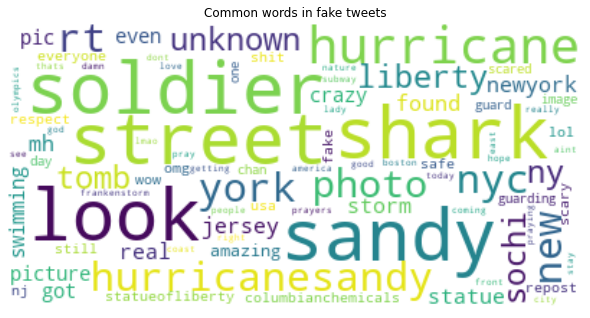

In [346]:
# Generate a word cloud of commonly used words in fake tweets

from collections import Counter
fake_cnt = Counter()
for text in train_data[train_data['label'] == 1].cleanText:
    for word in text.split():
        fake_cnt[word] += 1
        
freq = [w for (w, wc) in fake_cnt.most_common(100)]

wordcloud = WordCloud(max_font_size = 50, max_words=100, background_color='white').generate(" ".join(freq))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Common words in fake tweets")
plt.tight_layout(pad=0)
plt.show()

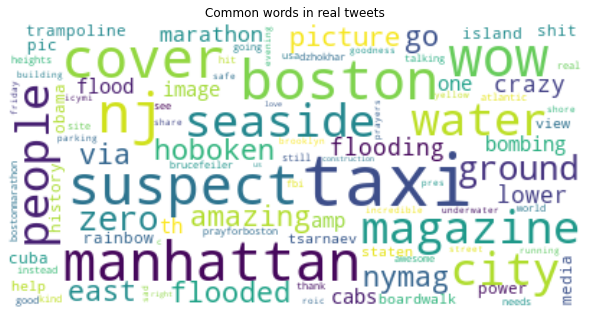

In [349]:
# Generate a word cloud of commonly used words in real tweets
from collections import Counter
real_cnt = Counter()
for text in train_data[train_data['label'] == 0].cleanWithoutFreq:
    for word in text.split():
        real_cnt[word] += 1
        
freq = [w for (w, wc) in real_cnt.most_common(100)]

wordcloud = WordCloud(max_font_size = 50, max_words=100, background_color='white').generate(" ".join(freq))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Common words in real tweets")
plt.tight_layout(pad=0)
plt.show()

In [291]:
# Convert cleanText into a numeric structure through Bag of Words (CountVectoriser)

In [ ]:
## Classification

In [352]:
# Use scklearn.model_selection and do train test split
X_train, X_test, y_train, y_test = train_test_split(train_data['cleanText'], train_data['label'], test_size = 0.2, random_state = 1)

In [354]:
# Set up TfidfTransformer to use CountVectorizer and calculate inverse document frequencies and encode tweets
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [355]:
# Setup pipeline object to automate machine learning workflow
# Try MultinomialNB first
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

mnb_model = pipeline.fit(X_train, y_train)
mnb_pred = mnb_model.predict(X_test)

In [372]:
# Apply Support Vector Machine
from sklearn.svm import LinearSVC
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC())
])

svc_model = pipeline.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)

In [374]:
# Apply a SGDClassifier
from sklearn.linear_model import SGDClassifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

sgd_model = pipeline.fit(X_train, y_train)
sgd_pred = sgd_model.predict(X_test)

In [ ]:
# Other models
# Source: https://scikit-learn.org/stable/_static/ml_map.png


MNB Accuracy: 87.955
SVC Accuracy: 90.045
SGD Accuracy: 89.773


Text(0.5, 1.0, 'SGD Classifier')

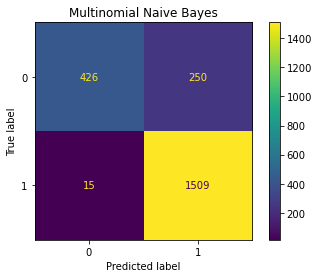

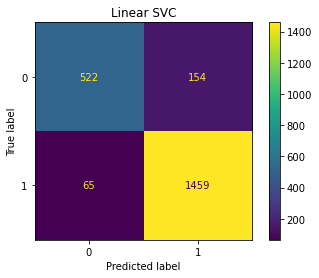

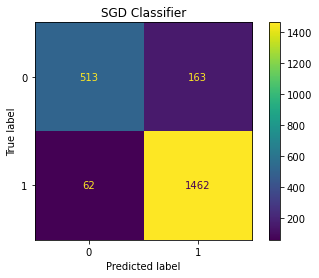

In [392]:
# ---- Evaluation & Comparison ---
# Establish 2 performance measures of a model
# Accuracy
# Confusion Matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix

#Accuracy scores of tested classifiers
mnb_score = metrics.accuracy_score(y_test, mnb_pred)
svc_score = metrics.accuracy_score(y_test, svc_pred)
sgd_score = metrics.accuracy_score(y_test, sgd_pred)

print("MNB Accuracy: %0.3f" % (mnb_score*100))
print("SVC Accuracy: %0.3f" % (svc_score*100))
print("SGD Accuracy: %0.3f" % (sgd_score*100))

allModels = [mnb_model, svc_model, sgd_model]
plot_confusion_matrix(mnb_model, X_test, y_test)
plt.title("Multinomial Naive Bayes")

plot_confusion_matrix(svc_model, X_test, y_test)
plt.title("Linear SVC")

plot_confusion_matrix(sgd_model, X_test, y_test)
plt.title("SGD Classifier")

In [398]:
# See the f1 score of Multinomial NB
from sklearn.metrics import f1_score
print("MNB F1 Score: %0.3f" % (f1_score(y_test, mnb_pred, average="micro") * 100))
print("SVC F1 Score: %0.3f" % (f1_score(y_test, svc_pred, average="micro") * 100))
print("SGD F1 Score: %0.3f" % (f1_score(y_test, sgd_pred, average="micro") * 100))

MNB F1 Score: 87.955
SVC F1 Score: 90.045
SGD F1 Score: 89.773


In [ ]:
# Evaluate and compare

In [ ]:
# Look into gridsearch

In [ ]:
# Hyperparameter Tuning

In [ ]:
# Evaluate and compare